**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. Normalized counts for intergenic bidirectionals and genes

        - sig_inter_nobs_dist_filtered.txt.gz
       
3. Gasperini and bidirectional overlaps

        - gasperini_bidirCalls_overlap.bed

**Output :**

1. Figures (overlap with validated pairs)

# Introduction

We took validated enhancers from Gasperini et al. and checked the recovery from our pairs compared to random gene--bidirectional pairs. Overall, we recover a significant overlap with the current gene--bidirectional pairs compared to a random set.

*Gasperini, Molly, et al. "A genome-wide framework for mapping gene regulation via cellular genetic screens." Cell 176.1 (2019): 377-390.*

# Load libraries

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(data.table) ## load files into R faster

# Functions


## Filter pairs

In [2]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, abs(distance_tes) < dist_DoPAD)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

## Get random pairs

In [3]:
shuffle_genes <- function(pairs_DT, seed=1235){
    #' shuffle genes within a chromosome pairs
    set.seed(seed)
    
    #1. assign a new data.table
    pairs_DT_shuffled_genes <- pairs_DT
    
    #2. reassigned gene names with a shuffled list
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    return(pairs_DT_shuffled_genes)
   
}

## Get overlaps with true pairs

In [4]:
map_overlaps <- function(overlap_DT, nascent_pairs) {
    
    #1. label the bidirectional IDs from a merged bed6 file
    #where the columns 6,7 and 8 are the coordinates for bidirectionals
    overlap_DT$bidirid <- paste0(overlap_DT$V6,':',
                                 overlap_DT$V7,'-',
                                 overlap_DT$V8)
    
    #2. get the annotations for genes and bidirectionals from nascent derived pairs 
    nascent_pairs_gene <- nascent_pairs[,c('transcript_1','transcript_2')]
    
    #3. add the gene id
    nascent_pairs_gene$gene_id <- as.character(lapply(strsplit(nascent_pairs_gene$transcript_1, ':'),
                                                      `[`, 1))
    
    #4. combine the overlap files with the nascent pairs file based in bidirectional id
    # This returns bidirectionals that overlap a feature (e.g. CRISPR-QTLs variant),
    # and the nascent pairs associated with than bidirectional
    overlap_DT_updated <- merge(overlap_DT, 
                                nascent_pairs_gene,
                                by.x='bidirid', by.y='transcript_2')
    
    #5. Get regions with matching gene ids from the bidirectional overlaps 
    # This final step ensures that both the pairs match. (i.e variant - gene/CRISPR-QTL == bidir - gene)
    overlap_DT_overlaps <- unique(overlap_DT_updated[overlap_DT_updated$V4 == overlap_DT_updated$gene_id,])
    
    return(overlap_DT_overlaps)
    
}

# Load data

## Significant pairs

In [5]:
sig_pairs_path <- '/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the counts tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [6]:
##add tissue ids
sig_pairs_file_names <- tools::file_path_sans_ext(basename(sig_pairs_path_files)) #as.character(lapply(strsplit(sig_pairs_path_files, '/'), `[`, 11))
sig_pairs_names_chr <- gsub("-", " ", as.character(lapply(strsplit(sig_pairs_file_names, '_'), `[`, 1)))
sig_pairs_names_chr

[1] "chr1"  "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17"
[10] "chr18" "chr19" "chr2"  "chr20" "chr21" "chr22" "chr3"  "chr4"  "chr5" 
[19] "chr6"  "chr7"  "chr8"  "chr9"  "chrX"  "chrY"

In [7]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)
dim(sig_pairs_path_DT)
head(sig_pairs_path_DT, 3)

[1] 3663224      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910


In [8]:
sig_pairs_path_DT$gene_id <- as.character(lapply(strsplit(sig_pairs_path_DT$transcript_1, ':'),
                                                      `[`, 1))
head(sig_pairs_path_DT, 3)

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847,A3GALT2
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207,A3GALT2
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910,A3GALT2


In [9]:
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)
nrow(sig_pairs_path_DT_filt)
head(sig_pairs_path_DT_filt, 3)

[1] 1440890

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847,A3GALT2
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207,A3GALT2
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910,A3GALT2


In [10]:
##Get unique pairs from significant data
unique_pairs <- unique(sig_pairs_path_DT_filt[,c('transcript_1',
                                                 'transcript_2')])

nrow(unique_pairs)
head(unique_pairs, 3)

[1] 1094246

transcript_1,transcript_2
<chr>,<chr>
A3GALT2:NM_001080438.1,chr1:33036652-33037238
A3GALT2:NM_001080438.1,chr1:33224694-33224966
A3GALT2:NM_001080438.1,chr1:33242850-33243170


## Counted transcripts used in correlation

In [11]:
counted_txpts <- data.table::fread('/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/genes_inter_bidir_filtered.tsv.gz')
counted_txpts$gene_id <- as.character(lapply(strsplit(counted_txpts$gene_transcript, ':'),
                                                      `[`, 1)) 
nrow(counted_txpts)
head(counted_txpts, 3)

[1] 350859

chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr19,58351969,58355183,A1BG-AS1:NR_015380.2,.,+,0.4715395,0.275847512,0.350156404,0.289034470,⋯,8.908832855,9.3601802570,1.126521e+01,24.003756,23.515781,22.649555,21.094696,23.696213379,22.427576708,A1BG-AS1
chr19,58345182,58353492,A1BG:NM_130786.4,.,-,0.6391889,0.413680061,0.742015737,0.722426895,⋯,1.293155683,1.3308983947,1.224210e+00,2.425766,1.773117,2.165353,2.375756,2.301772168,2.450560985,A1BG
chr10,50799408,50885627,A1CF:NM_014576.4,.,-,0.0000000,0.001591118,0.002164006,0.002778636,⋯,0.001835253,0.0008409737,9.417236e-04,0.000000,0.000000,0.000000,0.000000,0.002545294,0.001178184,A1CF


# Analysis

## Randomize pairs

In [12]:
## Get a shuffled gene list
## This is done for list in each chromosome (hence before merge lists)
sig_pairs_path_DT_shuffle_list <- lapply(sig_pairs_path_DT_list, 
                                         shuffle_genes)

## merge the shuffled genes
sig_pairs_path_DT_shuffle <- do.call(rbind, sig_pairs_path_DT_shuffle_list)
dim(sig_pairs_path_DT_shuffle)
head(sig_pairs_path_DT_shuffle, 3)

[1] 3663224      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,CDC73:NM_024529.5,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,NBPF14:NM_015383.2,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,ACTG1P20:NR_033926.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910


In [13]:
##filter the pairs
sig_pairs_path_DT_shuffle_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT_shuffle)

dim(sig_pairs_path_DT_shuffle_filt)
head(sig_pairs_path_DT_shuffle_filt,3)

[1] 1440890      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,CDC73:NM_024529.5,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,NBPF14:NM_015383.2,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,ACTG1P20:NR_033926.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910


## Gasperini pair overlaps

Overlap between Gasperini crispr-QTLs with bidirectionals was done with `bedtools`.

`16_bidir_gene_overlap_Gasperini2019.sbatch`



```sh
#!/bin/bash

#SBATCH --job-name=nascent_pairs_overlap_gasperini2019
#SBATCH --output=/scratch/Users/rusi2317/e_and_o/%x_%j.out
#SBATCH --error=/scratch/Users/rusi2317/e_and_o/%x_%j.err
#SBATCH --time=00:10:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=100MB
#SBATCH --partition short
#SBATCH --mail-type=FAIL
#SBATCH --mail-user=rutendo.sigauke@cuanschutz.edu

module purge
module load bedtools/2.28.0

###########################
##initialize files       ## 
###########################
wd=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38
gasperini=${wd}/cre_gene_pairs/Gasperini2019/Gasperini_2019_enhancer_gene_pairs_hg38_sorted.bed
bidirs=${wd}/processed_data/correlations/inter/significant
outdir=${wd}/processed_data/gasperini_nascent_pairs

mkdir -p ${outdir}

bidirectional_calls=/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_tfit_dreg_bidirectionals.bed

###########################
##Get overlaps ############
###########################
#1: get significant pairs from home directory

#2: how many of the gRNA regions are in bidirectional regions
bedtools intersect -a ${gasperini} -b ${bidirectional_calls} -wa -wb > ${outdir}/gasperini_bidirCalls_overlap.bed

#3: get pair overlaps
##Tissues
##column 13 are the PCC and column 16 are the number of observations (i.e. number of samples in correlation)
zcat ${bidirs}/* | grep -v 'transcript_1' |  awk -F'\t' '{if ($13 < -0.6 || $13 > 0.6) print $0}' OFS='\t' | awk -F'\t' '{if ($16 >10) print $10}' OFS='\t' | tr ':' '\t' | tr '-' '\t'| sort -k 1,1 -k2,2n | uniq | bedtools intersect -a ${gasperini} -b - -wa -wb | uniq > ${outdir}/gasperini_tissue_bidir_intersect_0.6.bed

zcat ${bidirs}/* | grep -v 'transcript_1' |  awk -F'\t' '{if ($13 < -0.7 || $13 > 0.7) print $0}' OFS='\t' | awk -F'\t' '{if ($16 >10) print $10}' OFS='\t' | tr ':' '\t' | tr '-' '\t'| sort -k 1,1 -k2,2n | uniq | bedtools intersect -a ${gasperini} -b - -wa -wb | uniq > ${outdir}/gasperini_tissue_bidir_intersect_0.7.bed

zcat ${bidirs}/* | grep -v 'transcript_1' |  awk -F'\t' '{if ($13 < -0.8 || $13 > 0.8) print $0}' OFS='\t' | awk -F'\t' '{if ($16 >10) print $10}' OFS='\t' | tr ':' '\t' | tr '-' '\t'| sort -k 1,1 -k2,2n | uniq | bedtools intersect -a ${gasperini} -b - -wa -wb | uniq > ${outdir}/gasperini_tissue_bidir_intersect_0.8.bed

zcat ${bidirs}/* | grep -v 'transcript_1' |  awk -F'\t' '{if ($13 < -0.9 || $13 > 0.9) print $0}' OFS='\t' | awk -F'\t' '{if ($16 >10) print $10}' OFS='\t' | tr ':' '\t' | tr '-' '\t' | sort -k 1,1 -k2,2n | uniq | bedtools intersect -a ${gasperini} -b - -wa -wb | uniq > ${outdir}/gasperini_tissue_bidir_intersect_0.9.bed


echo "DONE!"

```

### How many CRISPR-QTLs overlap bidirectional transcripts

Total pairs from CRISP-QTLs = `664`

In [14]:
gasperini_bidirectionals <- data.table::fread('/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_bidirCalls_overlap.bed')
gasperini_bidirectionals$bidir_id <- paste0(gasperini_bidirectionals$V6,':',
                                           gasperini_bidirectionals$V7,'-',
                                           gasperini_bidirectionals$V8)
head(gasperini_bidirectionals, 3)
nrow(gasperini_bidirectionals)
print(paste("Pairs with enhancer overlapping bidirectionals =", nrow(unique(gasperini_bidirectionals[,c(1,2,3,4)]))))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id
<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>
chr1,1134850,1135934,NADK,FALSE,chr1,1134922,1135218,tfit,1,.,chr1:1134922-1135218
chr1,1134850,1135934,NADK,FALSE,chr1,1135575,1136169,dreg,35,.,chr1:1135575-1136169
chr1,12038249,12039371,MIIP,FALSE,chr1,12038675,12039055,dreg,5,.,chr1:12038675-12039055


[1] 644

[1] "Pairs with enhancer overlapping bidirectionals = 579"


In [15]:
#filter for bidirectionals that were intergenic and also transcribed (analyzed in correlations)
gasperini_bidirectionals_transcribed <- gasperini_bidirectionals[gasperini_bidirectionals$bidir_id %in%
                                                                 counted_txpts$gene_transcript,]

#get unique CRISPR-QTL and Gene pairs
gasperini_bidirectionals_unique <- unique(gasperini_bidirectionals_transcribed[,c('V1','V2','V3','V4')])
head(gasperini_bidirectionals_unique, 3)
print(paste("Pairs that overlap bidirectionals that are trancribed =",nrow(gasperini_bidirectionals_unique)))

V1,V2,V3,V4
<chr>,<int>,<int>,<chr>
chr1,1134850,1135934,NADK
chr1,12038249,12039371,MIIP
chr1,25933356,25934013,CD52


[1] "Pairs that overlap bidirectionals that are trancribed = 565"


In [16]:
#Also get pairs for which genes are also transcribed
gasperini_bidirectionals_unique_transcribed_nascent <- gasperini_bidirectionals_unique[gasperini_bidirectionals_unique$V4
                                                                                       %in%
                                                                                       counted_txpts$gene_id,]
head(gasperini_bidirectionals_unique_transcribed_nascent, 3)
print(paste("Pairs that overlap bidirectionals AND genes that are trancribed =",
            nrow(gasperini_bidirectionals_unique_transcribed_nascent)))

V1,V2,V3,V4
<chr>,<int>,<int>,<chr>
chr1,1134850,1135934,NADK
chr1,12038249,12039371,MIIP
chr1,25933356,25934013,CD52


[1] "Pairs that overlap bidirectionals AND genes that are trancribed = 536"


### Get overlaps with tissue pairs

In [17]:
crisprQtl_bidirGene_overlaps <- map_overlaps(overlap_DT = gasperini_bidirectionals, 
                                             nascent_pairs = sig_pairs_path_DT_filt)
head(crisprQtl_bidirGene_overlaps, 3)
print(paste("Pairs from CRISPR-QTLs that overlap pairs from bidir~gene =",
           nrow(crisprQtl_bidirGene_overlaps)))

bidirid,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id,transcript_1,gene_id
<chr>,<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:3805815-3806335,chr10,3805919,3806186,KLF6,TRUE,chr10,3805815,3806335,"tfit,dreg",112,.,chr10:3805815-3806335,KLF6:NM_001300.6,KLF6
chr10:3809861-3810521,chr10,3810115,3810460,KLF6,TRUE,chr10,3809861,3810521,"tfit,dreg",112,.,chr10:3809861-3810521,KLF6:NM_001300.6,KLF6
chr10:4941408-4941952,chr10,4941458,4942029,AKR1C1,TRUE,chr10,4941408,4941952,"tfit,dreg",58,.,chr10:4941408-4941952,AKR1C1:NM_001353.6,AKR1C1


[1] "Pairs from CRISPR-QTLs that overlap pairs from bidir~gene = 209"


In [18]:
percent_recovered_all <- (nrow(crisprQtl_bidirGene_overlaps)/664)*100
percent_recovered_transcribed <- (nrow(crisprQtl_bidirGene_overlaps)/
                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100
print(paste("Percent Overlap (All) =", signif(percent_recovered_all, 4)))
print(paste("Percent Overlap (Transcribed) =", signif(percent_recovered_transcribed, 4)))


[1] "Percent Overlap (All) = 31.48"
[1] "Percent Overlap (Transcribed) = 38.99"


### Get overlaps with random pairs

In [19]:
crisprQtl_bidirGene_overlaps_random <- map_overlaps(overlap_DT = gasperini_bidirectionals, 
                                             nascent_pairs = sig_pairs_path_DT_shuffle_filt)
head(crisprQtl_bidirGene_overlaps_random, 3)
print(paste("Random pairs from CRISPR-QTLs that overlap pairs from bidir~gene =",
           nrow(crisprQtl_bidirGene_overlaps_random)))

bidirid,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id,transcript_1,gene_id
<chr>,<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr11:65421143-65421641,chr11,65421038,65421622,ATG2A,TRUE,chr11,65421143,65421641,dreg,187,.,chr11:65421143-65421641,ATG2A:NM_015104.3,ATG2A
chr11:65471931-65472579,chr11,65471949,65472508,ATG2A,FALSE,chr11,65471931,65472579,"tfit,dreg",187,.,chr11:65471931-65472579,ATG2A:NM_015104.3,ATG2A
chr11:75559074-75559648,chr11,75558947,75559797,SERPINH1,TRUE,chr11,75559074,75559648,"tfit,dreg",176,.,chr11:75559074-75559648,SERPINH1:NM_001235.5,SERPINH1


[1] "Random pairs from CRISPR-QTLs that overlap pairs from bidir~gene = 10"


In [20]:
percent_random_all <- (nrow(crisprQtl_bidirGene_overlaps_random)/664)*100
percent_random_transcribed <- (nrow(crisprQtl_bidirGene_overlaps_random)/
                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100
print(paste("Percent Overlap Random (All) =", signif(percent_random_all, 4)))
print(paste("Percent Overlap Random (Transcribed) =", signif(percent_random_transcribed, 4)))

[1] "Percent Overlap Random (All) = 1.506"
[1] "Percent Overlap Random (Transcribed) = 1.866"


### Assess multiple overlaps

In [21]:
#1: Generate a list of seeds (here 1 to 1000)
range_seeds <- seq(1, 1000, 1)

#2: Initialize a list for populating the overlaps
random_overlap <- list()

for (i in 1:length(range_seeds)){
    #3: shuffle gene names using the seeding above
    sig_pairs_shuffle_list <- lapply(sig_pairs_path_DT_list, 
                                     shuffle_genes, 
                                     seed=i)
    
    #4: combine the shuffled gene-bidir data.tables
    sig_pairs_shuffle <- do.call(rbind, sig_pairs_shuffle_list)

    #5: filter the pairs as before
    sig_pairs_shuffle_filt <- removing_DoPAD_bidirs(sig_pairs_shuffle)
    
    #6: Get overlaping pairs and store the values in list
    random_overlap_dt <- map_overlaps(overlap_DT = gasperini_bidirectionals,
                                      nascent_pairs = sig_pairs_shuffle_filt)
    
    #7: Count the overlaps
    random_overlap[[i]] <- nrow(random_overlap_dt)
    
}

In [22]:
random_overlap_df <- data.frame(random_overlap=as.numeric(random_overlap))
random_overlap_df$percent_overlap_all <- (as.numeric(random_overlap_df$random_overlap)/664)*100
random_overlap_df$percent_overlap_transcribed <- (as.numeric(random_overlap_df$random_overlap)/
                                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100

head(random_overlap_df)

,random_overlap,percent_overlap_all,percent_overlap_transcribed
,<dbl>,<dbl>,<dbl>
1,10,1.506024,1.8656716
2,5,0.753012,0.9328358
3,7,1.054217,1.3059701
4,5,0.753012,0.9328358
5,7,1.054217,1.3059701
6,10,1.506024,1.8656716


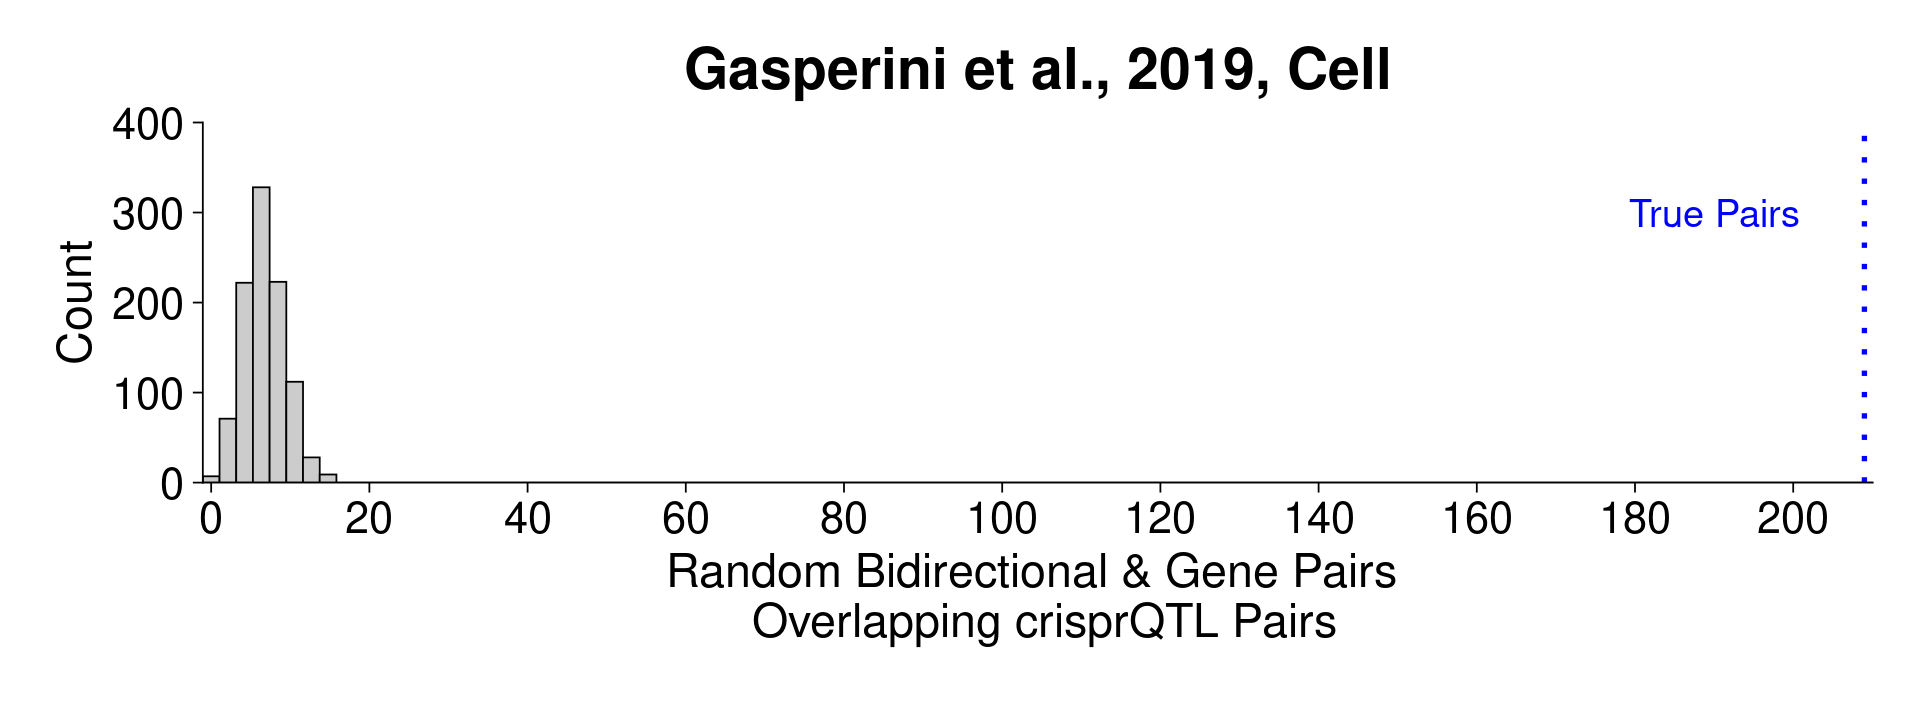

In [23]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotA <- ggplot(random_overlap_df, aes(x=random_overlap)) + 
geom_histogram(color="black", fill="gray80", bins = 100) +
geom_vline(xintercept = nrow(crisprQtl_bidirGene_overlaps),
           linetype="dotted", 
                color = "blue", size=1.5) +
scale_x_continuous(expand = c(0, 0),
                   #limits = c(0, 220),
                   breaks = seq(0,300,20)) +
scale_y_continuous(expand = c(0, 0),
                   limits = c(0,400),
                   breaks = seq(0,400,100)) +
annotate(geom="text", size=8, x=190, y=300, label="True Pairs",
              color="blue") +
theme_cowplot(24) +
  labs(title = "Gasperini et al., 2019, Cell", 
       y = "Count",
       x = "Random Bidirectional & Gene Pairs \n Overlapping crisprQTL Pairs") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(1,1,1.5,1.2, "cm"))

overlap_plotA

In [24]:
ggsave(overlap_plotA, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gasperini_nascent_overlaps.pdf',
      bg = "transparent")

ggsave(overlap_plotA, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gasperini_nascent_overlaps.png',
      bg = "transparent")

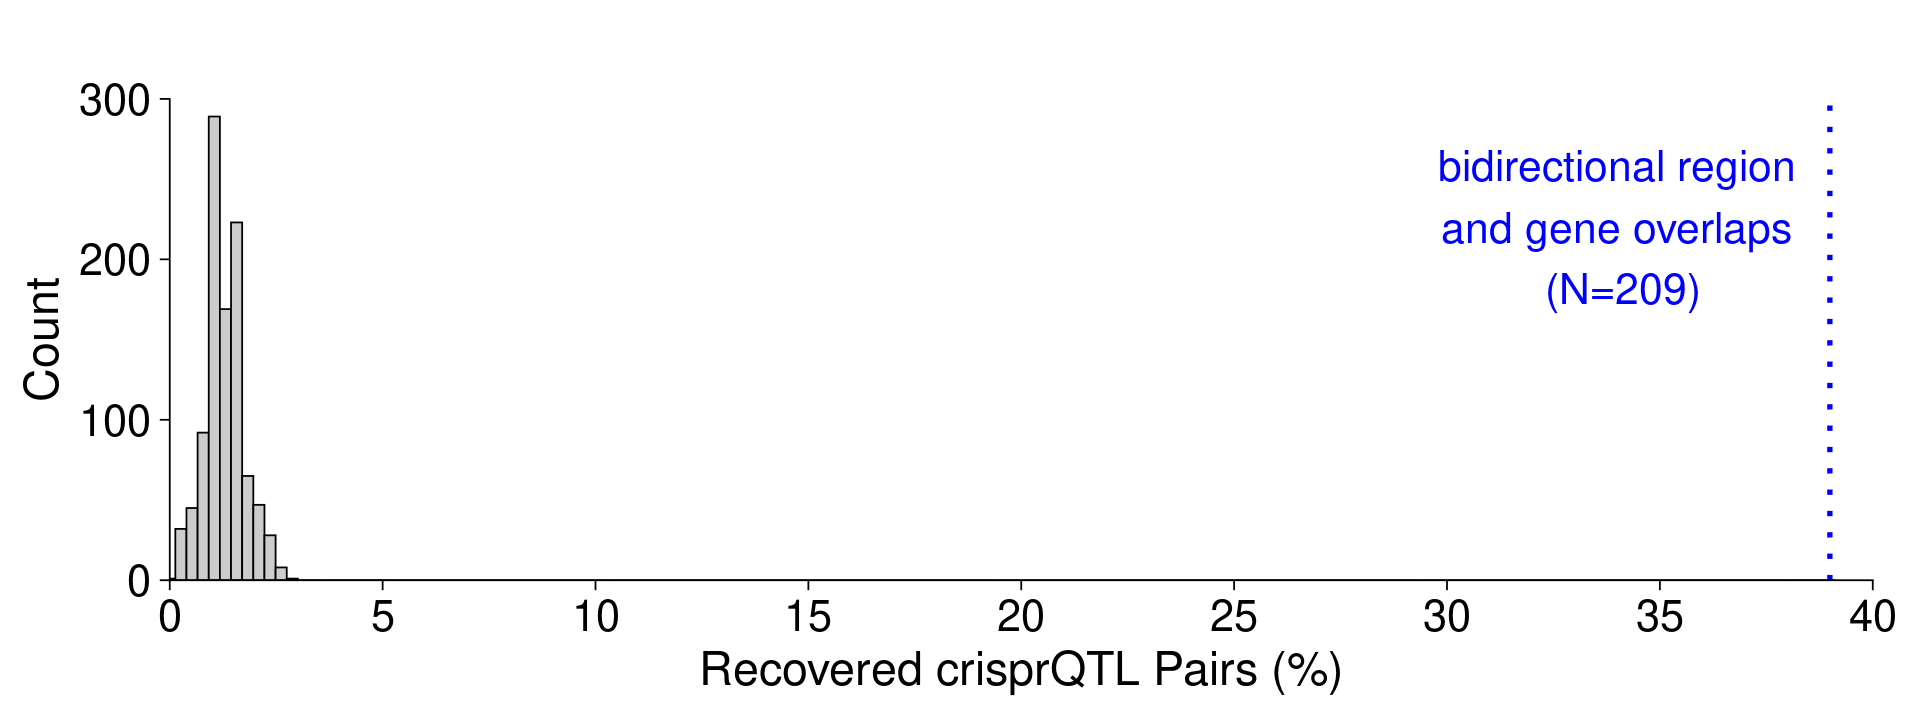

In [27]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotB <- ggplot(random_overlap_df, aes(x=percent_overlap_transcribed)) + 
geom_histogram(color="black", fill="gray80", bins = 150) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dotted", 
                color = "blue", size=1.5) +
scale_x_continuous(expand = c(0, 0),
                   breaks=seq(0,60,5)) +
scale_y_continuous(expand = c(0, 0)) +
annotate(geom="text", size=9,
         x=percent_recovered_transcribed-5,
         y=220, 
         label=paste0("bidirectional region\n and gene overlaps \n (N=",
                      nrow(crisprQtl_bidirGene_overlaps),")"),
         color="blue") +
coord_cartesian(xlim=c(0,40), ylim=c(0,300)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plotB

In [28]:
ggsave(overlap_plotB, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gasperini_nascent_overlaps_percent.pdf',
      bg = "transparent")

ggsave(overlap_plotB, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gasperini_nascent_overlaps_percent.png',
      bg = "transparent")

### Calculate empirical p-value

In [29]:
empirical_pval <- function(t_rep, t, alternative = c("two.sided", "less", "greater")) {

  alternative <- match.arg(alternative)

  r <- sum(t_rep > t)
  n <- length(t_rep)
  p <- (r + 1) / (n + 1) # instead of r/n, since the r replicates and the data are assumed from the null

  if (alternative == "greater") {
    pval <- p
  } else if (alternative == "less") {
    pval <- 1 - p
  } else if (alternative == "two.sided") {
    pval <- 2 * min(p, 1 - p)
  }
  return(pval)
}

In [30]:
empirical_pval(as.numeric(random_overlap_df$random_overlap),
               nrow(crisprQtl_bidirGene_overlaps), 
                    alternative = "greater")

[1] 0.000999001

# Session Information

In [31]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] data.table_1.14.2 cowplot_1.1.1     ggplot2_3.3.6    

loaded via a namespace (and not attached):
 [1] pillar_1.8.1      compiler_3.6.0    R.methodsS3_1.8.2 R.utils_2.12.0   
 [5] base64enc_0.1-3   tools_3.6.0       digest_0.6.29     uuid_1.1-0       
 [9] jsonlite_1.8.0    evaluate_0.16     lifecycle_1.0.3   tibble_3.1.8     
[1